In [28]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from mobile_sam import SamAutomaticMaskGenerator
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [99]:
MOBILESAM_CHECPOINT_PATH = "./models/mobileSam/weights/mobile_sam.pt"
TEST = "checkpoints/adapter/cod/2025-10-14_11-44-23/best_model.pth"

In [103]:
ckpt = torch.load(MOBILESAM_CHECPOINT_PATH, map_location="cpu")
set(ckpt.keys())

{'image_encoder.head.bias',
 'image_encoder.head.weight',
 'image_encoder.layers.0.blocks.0.conv1.bn.bias',
 'image_encoder.layers.0.blocks.0.conv1.bn.num_batches_tracked',
 'image_encoder.layers.0.blocks.0.conv1.bn.running_mean',
 'image_encoder.layers.0.blocks.0.conv1.bn.running_var',
 'image_encoder.layers.0.blocks.0.conv1.bn.weight',
 'image_encoder.layers.0.blocks.0.conv1.c.weight',
 'image_encoder.layers.0.blocks.0.conv2.bn.bias',
 'image_encoder.layers.0.blocks.0.conv2.bn.num_batches_tracked',
 'image_encoder.layers.0.blocks.0.conv2.bn.running_mean',
 'image_encoder.layers.0.blocks.0.conv2.bn.running_var',
 'image_encoder.layers.0.blocks.0.conv2.bn.weight',
 'image_encoder.layers.0.blocks.0.conv2.c.weight',
 'image_encoder.layers.0.blocks.0.conv3.bn.bias',
 'image_encoder.layers.0.blocks.0.conv3.bn.num_batches_tracked',
 'image_encoder.layers.0.blocks.0.conv3.bn.running_mean',
 'image_encoder.layers.0.blocks.0.conv3.bn.running_var',
 'image_encoder.layers.0.blocks.0.conv3.bn.wei

In [104]:
t = torch.load(TEST, map_location="cpu")["model_state_dict"]
set(t.keys())

{'image_encoder.image_encoder.head.bias',
 'image_encoder.image_encoder.head.weight',
 'image_encoder.image_encoder.layers.0.blocks.0.conv1.bn.bias',
 'image_encoder.image_encoder.layers.0.blocks.0.conv1.bn.num_batches_tracked',
 'image_encoder.image_encoder.layers.0.blocks.0.conv1.bn.running_mean',
 'image_encoder.image_encoder.layers.0.blocks.0.conv1.bn.running_var',
 'image_encoder.image_encoder.layers.0.blocks.0.conv1.bn.weight',
 'image_encoder.image_encoder.layers.0.blocks.0.conv1.c.weight',
 'image_encoder.image_encoder.layers.0.blocks.0.conv2.bn.bias',
 'image_encoder.image_encoder.layers.0.blocks.0.conv2.bn.num_batches_tracked',
 'image_encoder.image_encoder.layers.0.blocks.0.conv2.bn.running_mean',
 'image_encoder.image_encoder.layers.0.blocks.0.conv2.bn.running_var',
 'image_encoder.image_encoder.layers.0.blocks.0.conv2.bn.weight',
 'image_encoder.image_encoder.layers.0.blocks.0.conv2.c.weight',
 'image_encoder.image_encoder.layers.0.blocks.0.conv3.bn.bias',
 'image_encoder.

In [83]:
print(ckpt["image_encoder.neck.0.weight"].shape)
print(ckpt["image_encoder.neck.1.weight"].shape)

torch.Size([256, 320, 1, 1])
torch.Size([256])


In [29]:
import os
import shutil
import random

# Parameters
task = "cod"  # replace with your task folder name
train_dir = f"./data/{task}/train"
val_dir = f"./data/{task}/val"
val_split = 0.2  # 20% of training data for validation

# Paths
train_images_dir = os.path.join(train_dir, "images")
train_masks_dir = os.path.join(train_dir, "masks")
val_images_dir = os.path.join(val_dir, "images")
val_masks_dir = os.path.join(val_dir, "masks")

# Create validation directories if they don't exist
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_masks_dir, exist_ok=True)

# List all images
all_images = sorted([f for f in os.listdir(train_images_dir) if f.endswith(".jpg")])
num_val = int(len(all_images) * val_split)

# Randomly select validation images
val_images = random.sample(all_images, num_val)

# Move images and corresponding masks
for img_name in val_images:
    # Move image
    shutil.move(os.path.join(train_images_dir, img_name),
                os.path.join(val_images_dir, img_name))
    
    # Construct corresponding mask filename
    mask_name = os.path.splitext(img_name)[0] + ".png"
    
    # Move mask
    shutil.move(os.path.join(train_masks_dir, mask_name),
                os.path.join(val_masks_dir, mask_name))

print(f"Moved {num_val} samples to validation set.")

Moved 960 samples to validation set.


In [30]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_training(path):
    df = pd.read_csv(path)

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Loss curves
    ax1.plot(df["epoch"], df["train_loss"], label="Train Loss", color="tab:blue", marker='o')
    ax1.plot(df["epoch"], df["val_loss"], label="Validation Loss", color="tab:orange", marker='s')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.grid(True, linestyle='--', alpha=0.5)

    # # Learning rate on secondary axis
    # ax2 = ax1.twinx()
    # ax2.plot(df["epoch"], df["lr"], color="tab:green", linestyle='--', label="Learning Rate")
    # ax2.set_ylabel("Learning Rate")
    # ax2.legend(loc="upper left")

    plt.title("Training/Validation Loss and Learning Rate")
    plt.tight_layout()
    plt.show()

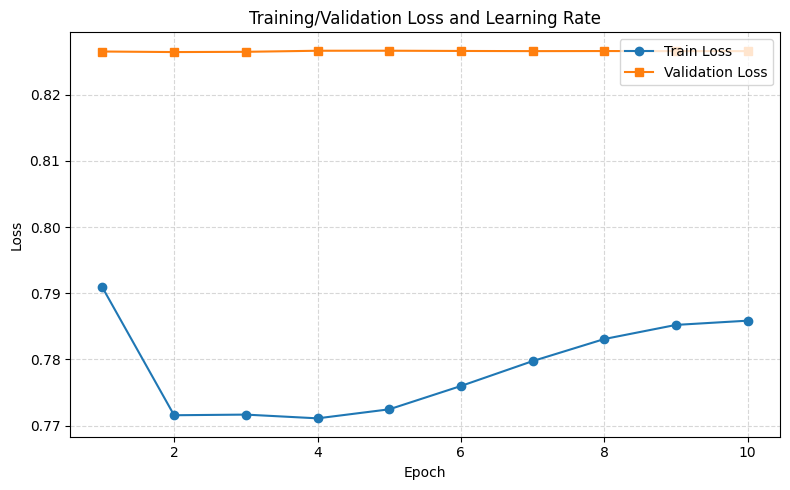

In [31]:
# Load CSV file
path = "./checkpoints/adapter/cod/2025-10-07_20-17-05/training_log.csv"
plot_training(path)

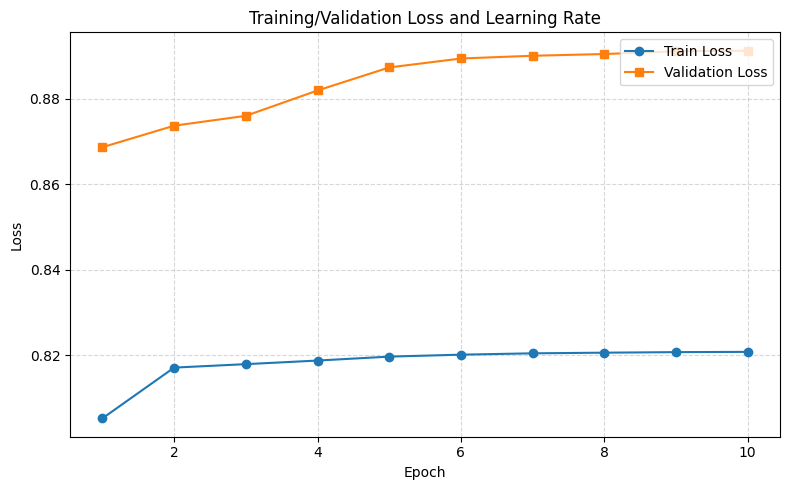

In [32]:
path = "./checkpoints/lora/cod/2025-10-08_16-21-10/training_log.csv"
plot_training(path)

In [85]:
model_type = "vit_t"
sam_checkpoint = "./models/mobileSam/weights/mobile_sam.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()

# predictor = SamPredictor(mobile_sam)
# predictor.set_image(<your_image>)
# masks, _, _ = predictor.predict(<input_prompts>)

LR SCALES: [0.08589934592000005, 0.10737418240000006, 0.13421772800000006, 0.1677721600000001, 0.20971520000000007, 0.2621440000000001, 0.3276800000000001, 0.4096000000000001, 0.5120000000000001, 0.6400000000000001, 0.8, 1.0]


Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

In [35]:
import glob
from PIL import Image

img_path = "./data/cod/train/images/*"

sizes = set()

for img_file in glob.glob(img_path):
    with Image.open(img_file) as img:
        sizes.add(img.size)  # (width, height)

print("Unique image sizes:")
for s in sorted(sizes):
    print(s)

Unique image sizes:
(220, 330)
(253, 450)
(300, 199)
(333, 499)
(343, 600)
(357, 637)
(360, 480)
(360, 640)
(361, 640)
(396, 533)
(400, 800)
(425, 640)
(426, 639)
(426, 640)
(426, 650)
(427, 640)
(428, 640)
(440, 640)
(443, 800)
(449, 799)
(449, 800)
(450, 600)
(450, 799)
(451, 800)
(455, 640)
(459, 639)
(465, 671)
(470, 688)
(479, 720)
(480, 480)
(480, 640)
(480, 720)
(481, 640)
(482, 720)
(495, 720)
(495, 746)
(499, 332)
(499, 333)
(500, 331)
(500, 333)
(500, 334)
(500, 374)
(500, 378)
(500, 800)
(508, 800)
(510, 739)
(512, 768)
(513, 768)
(516, 856)
(519, 800)
(523, 640)
(525, 800)
(528, 800)
(529, 549)
(530, 783)
(530, 800)
(531, 800)
(532, 416)
(532, 799)
(532, 800)
(533, 799)
(533, 800)
(534, 799)
(534, 800)
(535, 800)
(536, 799)
(536, 800)
(537, 799)
(537, 800)
(539, 1024)
(540, 720)
(544, 800)
(547, 800)
(550, 800)
(552, 800)
(559, 667)
(559, 800)
(560, 683)
(566, 800)
(571, 797)
(571, 800)
(573, 1024)
(574, 402)
(574, 800)
(575, 800)
(576, 432)
(576, 1024)
(577, 800)
(578, 434

(600, 800, 3)


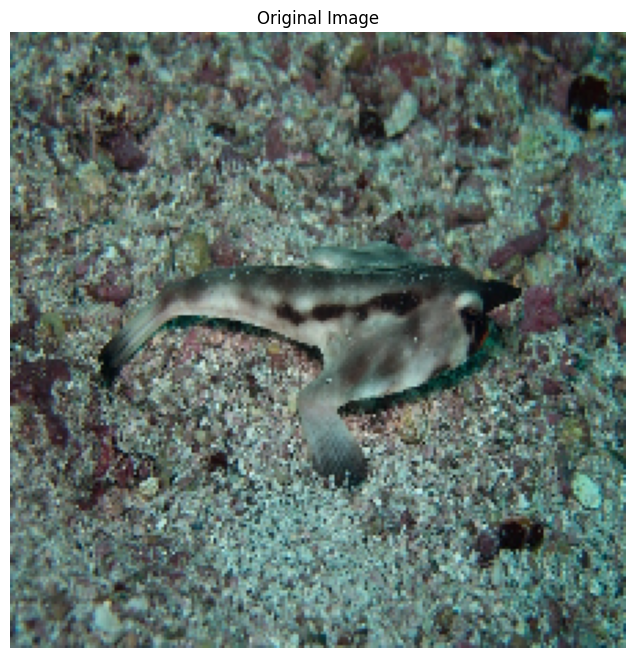

In [36]:
img_path = "./data/cod/train/images/COD10K-CAM-1-Aquatic-1-BatFish-1.jpg"

image_bgr = cv2.imread(img_path)

# 2. Convert BGR -> RGB for SAM
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_rgb, (224, 224))

print(image_rgb.shape)

# 3. Display original image
plt.figure(figsize=(8, 8))
plt.imshow(image_resized)
plt.axis("off")
plt.title("Original Image")
plt.show()


In [37]:
mask_generator = SamAutomaticMaskGenerator(mobile_sam)
masks = mask_generator.generate(image_rgb)

In [38]:
len(masks)

79

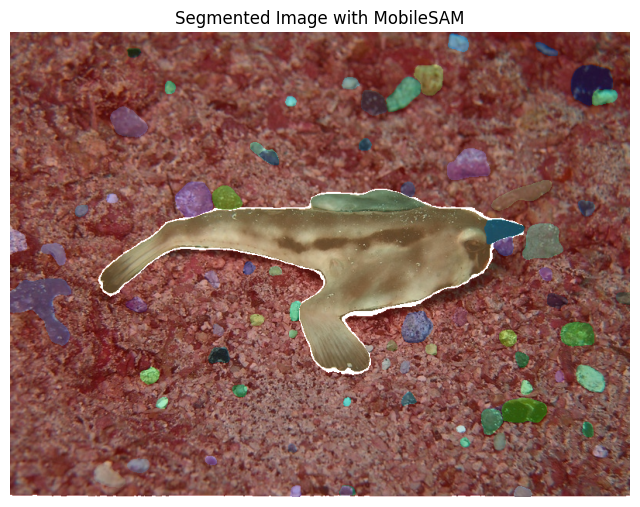

In [39]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0],
                   sorted_anns[0]['segmentation'].shape[1], 4))
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
show_anns(masks)
plt.axis("off")
plt.title("Segmented Image with MobileSAM")
plt.show()

In [62]:
# Load ground truth mask (white=object, black=background)
gt_path = "./data/cod/train/masks/COD10K-CAM-1-Aquatic-1-BatFish-1.png"
gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
gt_mask = (gt_mask > 127).astype(np.uint8)  # binarize (0 or 1)

def compute_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    if union == 0:
        return 0.0
    return intersection / union

In [63]:
best_mask = None
best_iou = -1

for m in masks:
    pred_mask = m['segmentation']
    iou = compute_iou(pred_mask, gt_mask)
    if iou > best_iou:
        best_iou = iou
        best_mask = pred_mask

print("Best IoU:", best_iou)

Best IoU: 0.9622425160735493


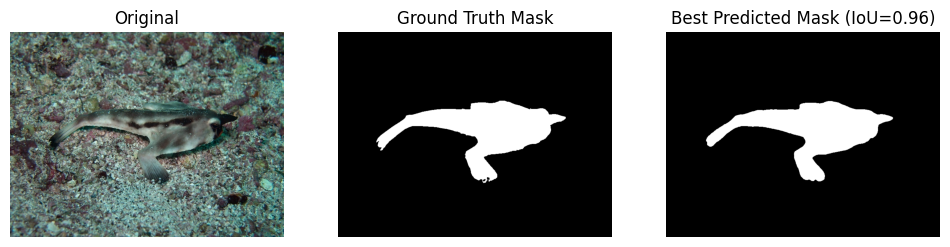

In [64]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(best_mask, cmap="gray")
plt.title(f"Best Predicted Mask (IoU={best_iou:.2f})")
plt.axis("off")

plt.show()

In [65]:
best_iou

np.float64(0.9622425160735493)

In [66]:
from losses import (
    CamouflagedObjectLoss,
    ShadowDetectionLoss,
    StructureSegmentationLoss
)

gt_mask_tensor = torch.from_numpy(gt_mask).float().unsqueeze(0).unsqueeze(0)
best_mask_tensor = torch.from_numpy(best_mask).float().unsqueeze(0).unsqueeze(0)

criterion = CamouflagedObjectLoss(w_bce=0, w_iou=1)
criterion(gt_mask_tensor, best_mask_tensor)



tensor(0.8692)

In [67]:
def to_tensor(mask):
    return torch.from_numpy(mask).float().unsqueeze(0).unsqueeze(0)

In [76]:
criterion = CamouflagedObjectLoss(w_bce=0, w_iou=1)
best_iou_test = 1

for m in masks:
    pred_mask = m['segmentation']
    
    iou_loss = criterion(to_tensor(gt_mask), to_tensor(best_mask))
    if iou_loss < best_iou_test:
        best_iou_test = iou_loss
        best_mask_test = pred_mask

print("Best IoU test:", best_iou_test)

Best IoU test: tensor(0.8692)


In [79]:
pred_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(600, 800))

In [78]:
best_mask_test

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(600, 800))

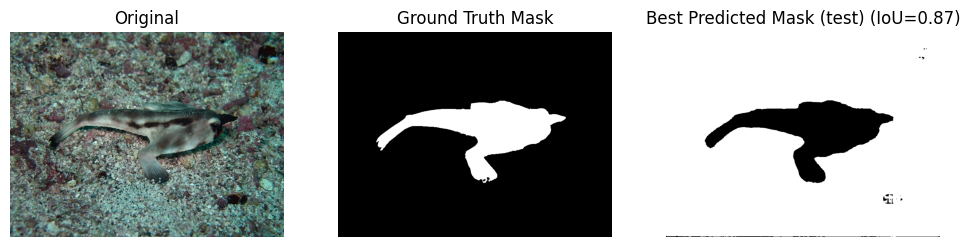

In [77]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(best_mask_test, cmap="gray")
plt.title(f"Best Predicted Mask (test) (IoU={best_iou_test:.2f})")
plt.axis("off")

plt.show()